## Bayesian nonparametrics

**Author:** Felipe Tobar
**Date:** 29 January, 2025

**Statement of originality:** The conceptual structure and teaching narrative of this notebook are original. ChatGPT 5.2 was used as a coding assistant for parts of the low-level implementation and plotting. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt

print_figs = True


plt.rcParams.update({
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
    "lines.linewidth": 3,
})


### 1) Density estimation

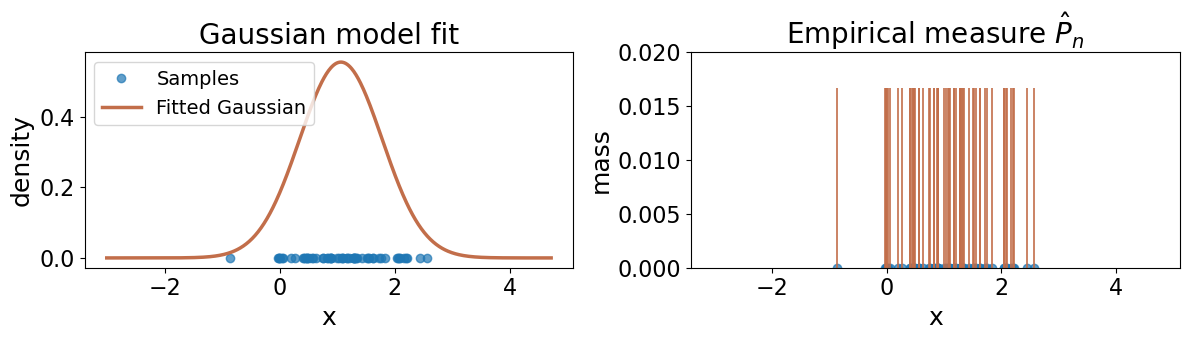

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- data: sample from a Gaussian ---
rng = np.random.default_rng(0)
n = 60
mu_true, sigma_true = 1.0, 0.8
x = rng.normal(mu_true, sigma_true, size=n)

# --- Gaussian fit (MLE) ---
mu_hat = x.mean()
sigma_hat = x.std(ddof=0)

# Grid for plotting the fitted Gaussian density
xx = np.linspace(x.min() - 3*sigma_hat, x.max() + 3*sigma_hat, 600)
gauss_pdf = (1.0 / (np.sqrt(2*np.pi) * sigma_hat)) * np.exp(
    -(xx - mu_hat)**2 / (2 * sigma_hat**2)
)

# ---------------- Side-by-side figures ----------------
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True)

# (i) Samples + fitted Gaussian
axes[0].plot(x, np.zeros_like(x), "o", alpha=0.7, label="Samples")
axes[0].plot(xx, gauss_pdf, linewidth=2.5, color="#C26E4A", label="Fitted Gaussian")
axes[0].set_title("Gaussian model fit")
axes[0].set_xlabel("x")
axes[0].set_ylabel("density")
axes[0].legend()

# (ii) Empirical measure as Dirac masses
axes[1].plot(x, np.zeros_like(x), "o", alpha=0.7, label="Samples")
axes[1].vlines(x, 0.0, 1.0 / n, color="#C26E4A",linewidth=1.2)
axes[1].set_ylim(0, 1.2 / n)
axes[1].set_title(r"Empirical measure $\hat P_n$")
axes[1].set_xlabel("x")
axes[1].set_ylabel("mass")
plt.tight_layout()


if print_figs:
    plt.savefig("../img/week4_density_estimation_2methods.pdf", format="pdf", bbox_inches="tight")
    

In [23]:
### 2) Finite mixture

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hd/761f4bvn2jz3pr3pm02m44k80000gn/T/ipykernel_30364/1659679017.py:31: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$p(x) = \sum c_ip(x | \phi_i)$')


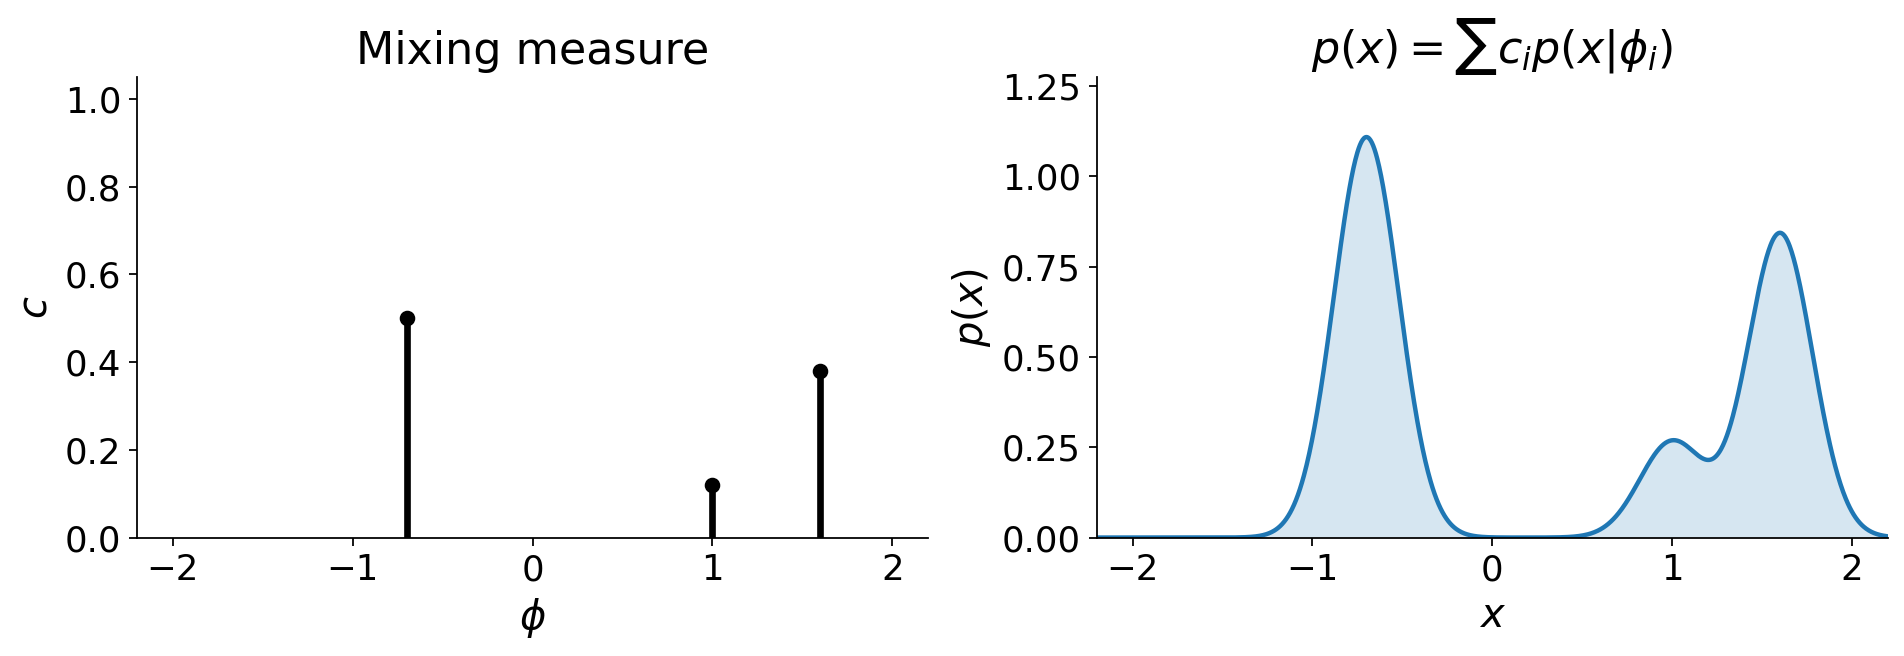

In [28]:
# --- Finite Gaussian mixture parameters (edit these to taste) ---
phi = np.array([-0.7, 1.0, 1.6])          # component locations (means)
c   = np.array([0.50, 0.12, 0.38])        # mixing weights (sum to 1)
sigma = 0.18                               # shared std. dev.

# --- Grid and mixture density ---
x = np.linspace(-2.2, 2.2, 1200)

def normal_pdf(x, mu, sig):
    return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-(x - mu)**2 / (2 * sig**2))

p = sum(ci * normal_pdf(x, mui, sigma) for ci, mui in zip(c, phi))

# --- Plot: weights (left) and density (right) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.2), dpi=160)

# (i) Discrete mixing measure: spikes at phi with heights c
ax = axes[0]
markerline, stemlines, baseline = ax.stem(phi, c, linefmt='k-', markerfmt='o', basefmt=' ')
plt.setp(markerline, markersize=6)
ax.set_title('Mixing measure')
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$c$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# (ii) Mixture density
ax = axes[1]
ax.set_title('$p(x) = \sum c_ip(x | \phi_i)$')
ax.plot(x, p, linewidth=2.0)
ax.fill_between(x, 0, p, alpha=0.18)
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(0, 1.15 * p.max())
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p(x)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(w_pad=2.0)


if print_figs:
    plt.savefig("../img/week4_mixing_measure.pdf", format="pdf", bbox_inches="tight")

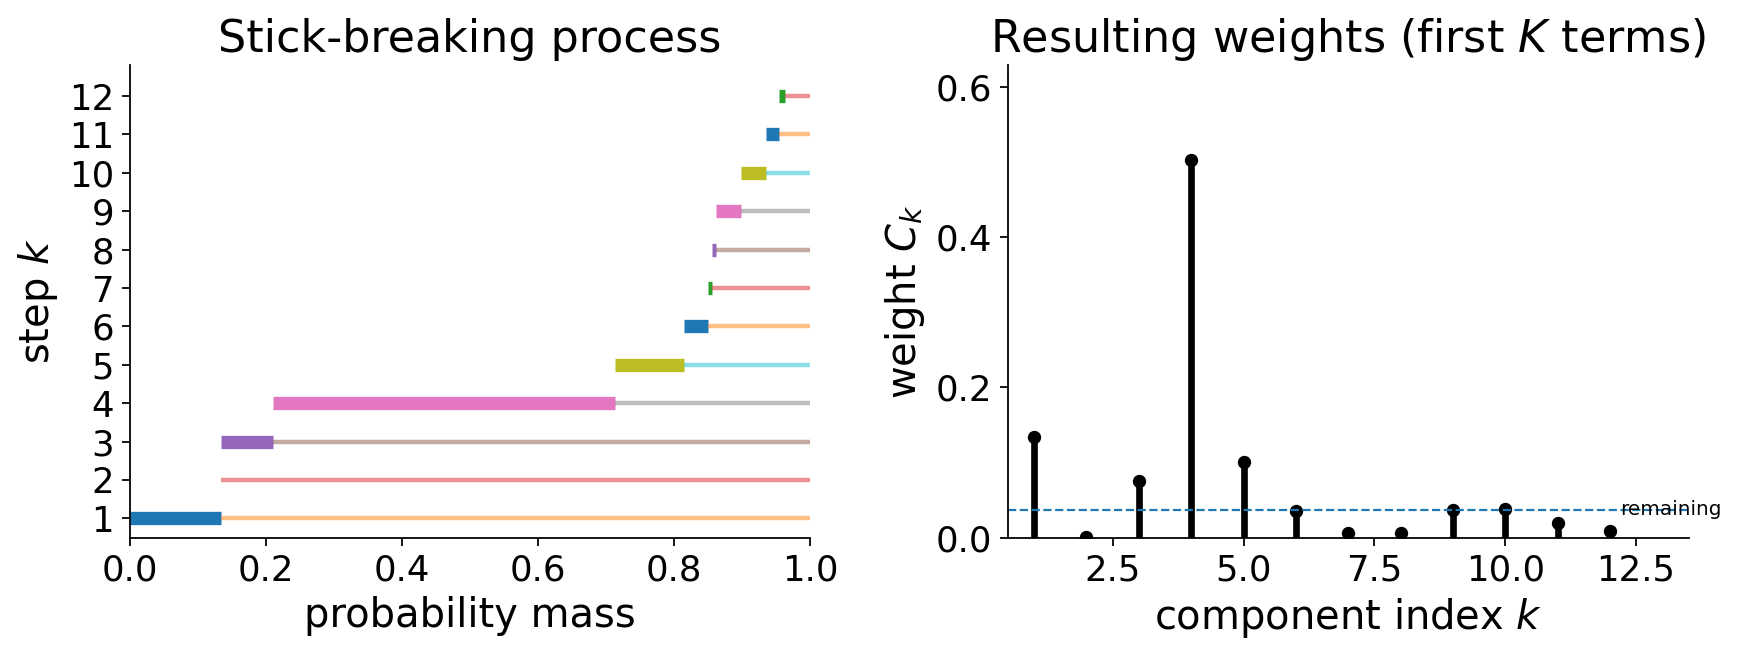

In [38]:
# --- Stick-breaking (GEM / DP weights): V_k ~ Beta(1, alpha) ---
rng = np.random.default_rng(0)
alpha = 5.0          # larger alpha -> more, smaller weights
K = 12                # number of displayed components

V = rng.beta(1.0, alpha, size=K)
C = np.empty(K)
rem = 1.0
for k in range(K):
    C[k] = rem * V[k]
    rem *= (1.0 - V[k])

# --- Two-panel illustration: breaks + resulting weights ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), dpi=160)

# (i) Stick being broken: show remaining stick shrinking and the piece broken off each step
ax = axes[0]
for k in range(K):
    left = C[:k].sum()
    right = left + C[k]
    # broken piece (assigned mass)
    ax.plot([left, right], [k+1, k+1], linewidth=6, solid_capstyle="butt")
    # remaining piece
    ax.plot([right, 1.0], [k+1, k+1], linewidth=2, alpha=0.5, solid_capstyle="butt")
ax.set_xlim(0, 1)
ax.set_ylim(0.5, K + 0.8)
ax.set_yticks(range(1, K+1))
ax.set_xlabel("probability mass")
ax.set_ylabel("step $k$")
ax.set_title("Stick-breaking process")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# (ii) Resulting weights C_k as a discrete distribution (like mixing weights)
ax = axes[1]
k_idx = np.arange(1, K+1)
markerline, stemlines, baseline = ax.stem(k_idx, C, linefmt='k-', markerfmt='o', basefmt=' ')
plt.setp(markerline, markersize=5)
ax.axhline(rem, linestyle="--", linewidth=1)  # leftover mass after K breaks
ax.text(K + 0.2, rem, "remaining", va="center", fontsize=9)
ax.set_xlim(0.5, K + 1.5)
ax.set_ylim(0, max(C.max(), rem) * 1.25)
ax.set_xlabel("component index $k$")
ax.set_ylabel(r"weight $C_k$")
ax.set_title(r"Resulting weights (first $K$ terms)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout(w_pad=2.0)



if print_figs:
    plt.savefig("../img/week4_stick_breaking.pdf", format="pdf", bbox_inches="tight")
    


### 3) DPs with different concentration params

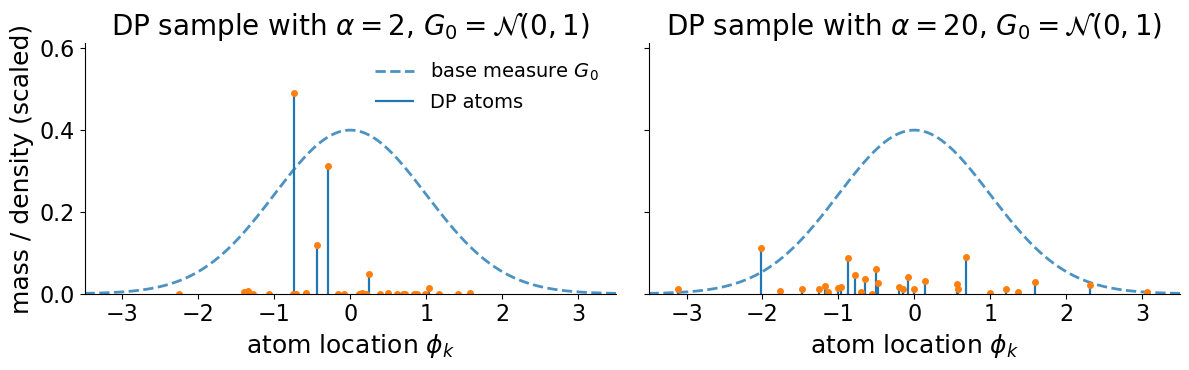

In [49]:
# --- DP draw via stick-breaking + atoms from base measure G0 ---
def sample_dp_atoms(alpha, K, rng):
    # Stick-breaking weights (GEM)
    V = rng.beta(1.0, alpha, size=K)
    w = np.empty(K)
    rem = 1.0
    for k in range(K):
        w[k] = rem * V[k]
        rem *= (1.0 - V[k])

    # Atoms from base measure G0 = N(0,1)
    phi = rng.normal(0.0, 1.0, size=K)

    # Sort by atom location for nicer plotting
    order = np.argsort(phi)
    return phi[order], w[order], rem

# --- setup ---
rng = np.random.default_rng(0)
K = 30
alpha1, alpha2 = 2, 20

phi1, w1, _ = sample_dp_atoms(alpha1, K, rng)
phi2, w2, _ = sample_dp_atoms(alpha2, K, rng)

# Base measure density (Gaussian N(0,1))
x = np.linspace(-3.5, 3.5, 800)
base_pdf = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3.8), sharey=True)

for ax, phi, w, a in [
    (axes[0], phi1, w1, alpha1),
    (axes[1], phi2, w2, alpha2),
]:
    # Base measure
    ax.plot(x, base_pdf, linestyle="--", linewidth=2.0, alpha=0.8,
            label=r"base measure $G_0$")

    # DP draw: discrete atoms
    ax.vlines(phi, 0.0, w, linewidth=1.6, label="DP atoms")
    ax.plot(phi, w, "o", markersize=4)

    ax.set_title(rf"DP sample with $\alpha={a}$, $G_0=\mathcal{{N}}(0,1)$")
    ax.set_xlabel(r"atom location $\phi_k$")
    ax.set_xlim(x.min(), x.max())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel(r"mass / density (scaled)")
axes[0].set_ylim(0, max(w1.max(), w2.max()) * 1.25)
axes[0].legend(frameon=False)

plt.tight_layout(w_pad=2.0)


if print_figs:
    plt.savefig("../img/week4_2DPs.pdf", format="pdf", bbox_inches="tight")
    